In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # disable Pandana multithreading 
os.environ["USE_PYGEOS"] = "0"  # suppress geopandas warning

In [11]:
import pandana
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# Proximity and Accessibility analysis using Pandana

Based on tutorial notebook: https://github.com/UDST/pandana/blob/main/examples/Pandana-demo.ipynb

In [ ]:
from pathlib import Path

data_

In [3]:
# load street network
nodes = gpd.read_file("data/nodes.shp")
edges = gpd.read_file("data/edges.shp")

# load vector data (buildings and parks)
parks = gpd.read_file("data/parks.shp")
buildings = gpd.read_file("data/buildings.shp")

In [5]:
# setup network
nodes = nodes.set_index("osmid", drop=False)
edges = edges.set_index(["u", "v"], drop=False)

network = pandana.Network(
    node_x=nodes["x"], 
    node_y=nodes["y"], 
    edge_from=edges["u"], 
    edge_to=edges["v"], 
    edge_weights=edges[["length"]],
)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 9576
Setting CH edge vector of size 26836
Range graph removed 27776 edges of 53672
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

## Proximity analysis 

In [6]:
# add point of interests to network
network.set_pois(
    category="parks",
    maxdist=1000,
    maxitems=25,
    x_col=parks.centroid.x,
    y_col=parks.centroid.y,
)

In [7]:
# for all nodes, find 3 closest parks within 800m
results = network.nearest_pois(
    distance=800,
    category="parks",
    num_pois=3,
    include_poi_ids=False
)

In [8]:
results.describe()

,1,2,3
count,9576.000000,9576.000000,9576.000000
mean,81.199442,126.881722,161.755679
std,80.091568,92.819564,101.321006
min,0.000000,0.000000,0.000000
25%,21.226500,60.415250,91.086248
50%,62.717501,111.404499,145.754005
75%,116.358997,172.584248,212.979248
max,800.000000,800.000000,800.000000


## Accessibility analysis

In [9]:
# add target points to network
node_ids = network.get_node_ids(parks.centroid.x, y_col=parks.centroid.y)
network.set(node_ids, name="parks")

In [10]:
# for all nodes, find how many parks fall within 800m
accessibility = network.aggregate(
    distance=800,
    type="count",
    name="parks"
)

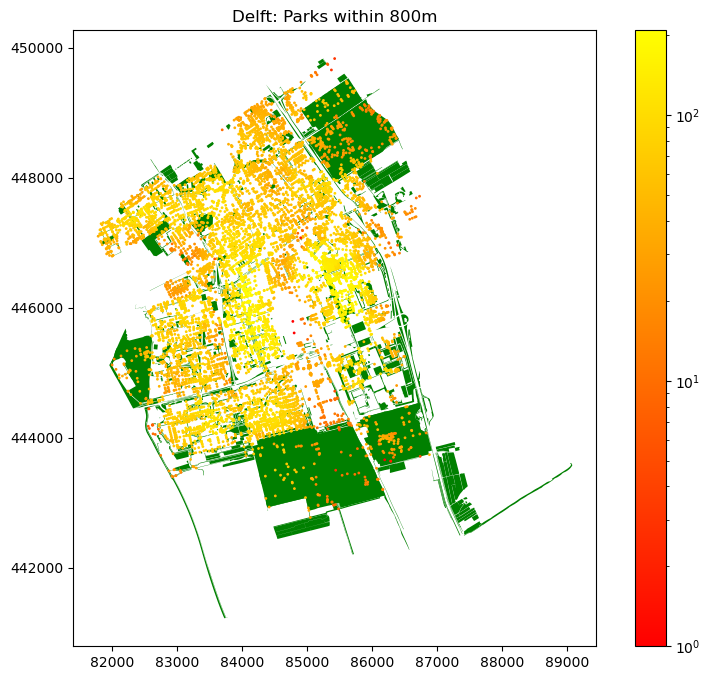

In [14]:
# visualize nodes using accessibility
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plt.title('Delft: Parks within 800m')
parks.plot(
    ax=ax,
    color="green"
)
plt.scatter(
    nodes["x"], 
    nodes["y"], 
    c=accessibility, 
    s=1, 
    cmap='autumn', 
    norm=matplotlib.colors.LogNorm()
)
cb = plt.colorbar()

In [15]:
# assign accessibility of buildings using closest nodes 
node_ids = network.get_node_ids(
    x_col=buildings.centroid.x, 
    y_col=buildings.centroid.y
)
buildings["accessibility"] = node_ids.map(accessibility.to_dict())

<Axes: title={'center': 'Delft: Parks within 800m'}>

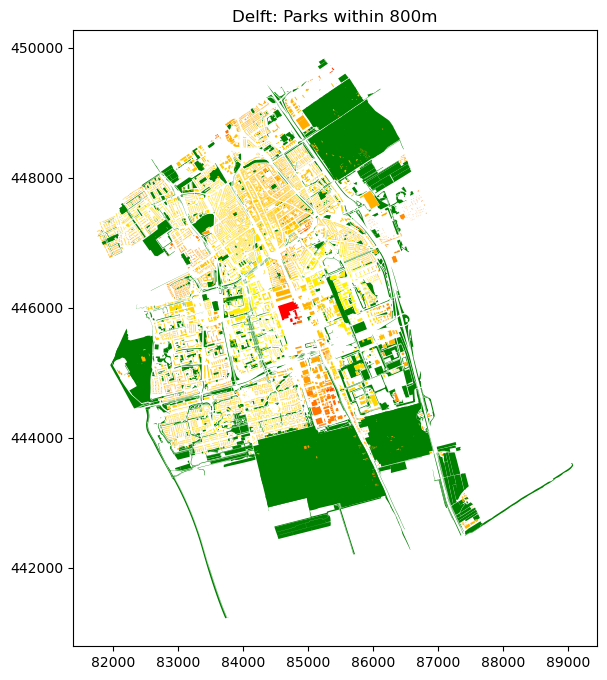

In [16]:
# visualize buildings using accessibility
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plt.title('Delft: Parks within 800m')
parks.plot(
    ax=ax,
    color="green"
)
buildings.plot(
    ax=ax,
    column="accessibility",  
    cmap="autumn",
    norm=matplotlib.colors.LogNorm(),
    figsize=(10,8),
)